# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

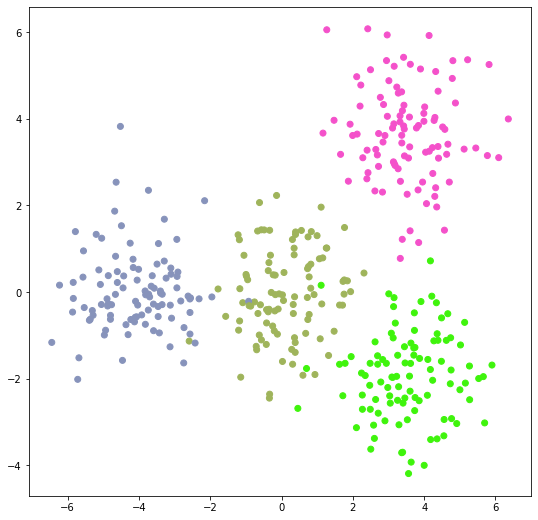

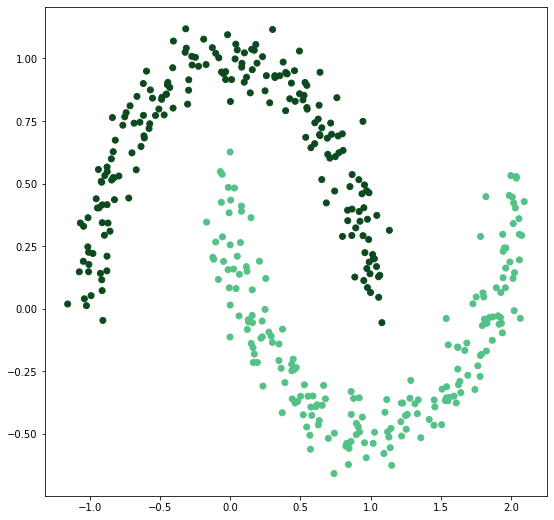

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = np.array([])
        self.X = None
        
    def compute_distance(self, X: np.array):
        distance = np.zeros((X.shape[0], len(self.centroids)))
        for i in range(len(X)):
            distance[i] = np.array([np.sum((X[i] - self.centroids[k]) ** 2) for k in range(len(self.centroids))])
        return distance
    
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        if self.init == "random":
            self.centroids = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (self.n_clusters, X.shape[1]))
        elif self.init == "sample":
            self.centroids = X[np.random.choice(X.shape[0], self.n_clusters)]
        elif self.init == "k-means++":
            self.centroids = X[np.random.choice(X.shape[0], 1)]
            for _ in range(self.n_clusters - 1):
                distance = self.compute_distance(X)
                M = np.min(self.compute_distance(X), axis=1)
                probability = M / np.sum(M)
                index = np.random.choice(X.shape[0], p = probability)
                self.centroids = np.append(self.centroids, [X[index]], axis=0)
            
        for _ in range(self.max_iter):
            cluster = np.argmin(self.compute_distance(X), axis=1)
            centroids = np.zeros((self.n_clusters, X.shape[1]))
            clusters_size = np.zeros(self.n_clusters)
            for i in range(len(X)):
                centroids[cluster[i]] += X[i]
                clusters_size[cluster[i]] += 1
            centroids = centroids / clusters_size.reshape((self.n_clusters, 1))
            self.centroids = centroids
    
        

    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        return np.argmin(self.compute_distance(X), axis=1)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

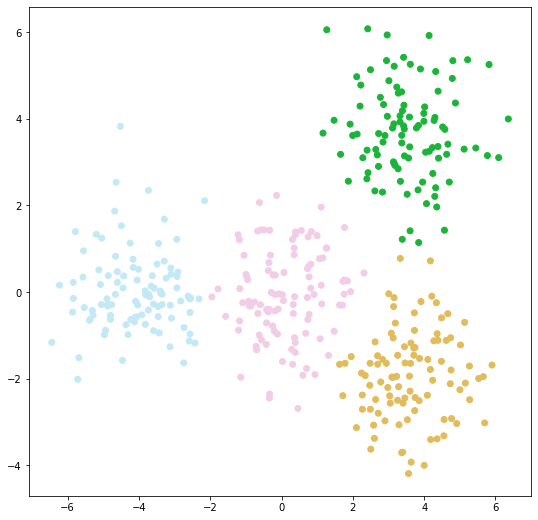

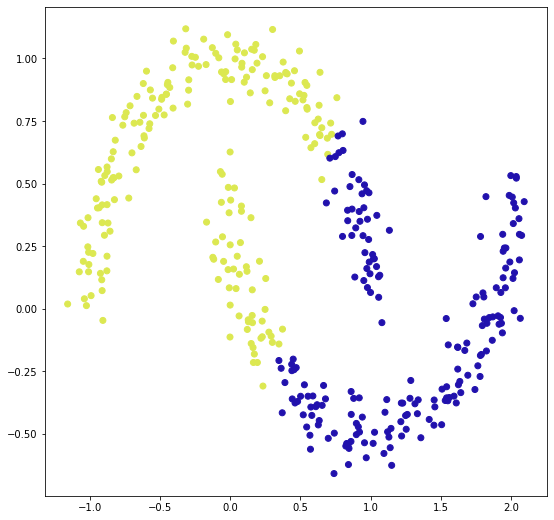

In [5]:
kmeans = KMeans(n_clusters=4, init = "k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        self.tree = None
        self.n_clusters = 0
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.tree = KDTree(X, metric=self.metric, leaf_size=self.leaf_size)
        result = np.zeros(X.shape[0]).astype(int)
        for i in range(len(X)):
            if result[i] != 0: continue
            neighbours = self.tree.query_radius(X[i].reshape(1, -1), self.eps)[0]
            if len(neighbours) < self.min_samples:
                result[i] = -1
                continue
            self.n_clusters += 1
            result[i] = self.n_clusters
            d = deque(neighbours)
            while len(d) != 0:
                point = d.pop()
                if result[point] == -1:
                    result[point] = self.n_clusters
                if result[point] != 0: 
                    continue
                result[point] = self.n_clusters
                new_neighbors = self.tree.query_radius(X[point].reshape(1, -1), self.eps)[0]
                if len(new_neighbors) >= self.min_samples:
                    d.extend(new_neighbors)
                    d = deque(set(d))
        
        result -= 1
        result = np.array([x if x != -2 else np.max(result) for x in result])
        return result
                

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

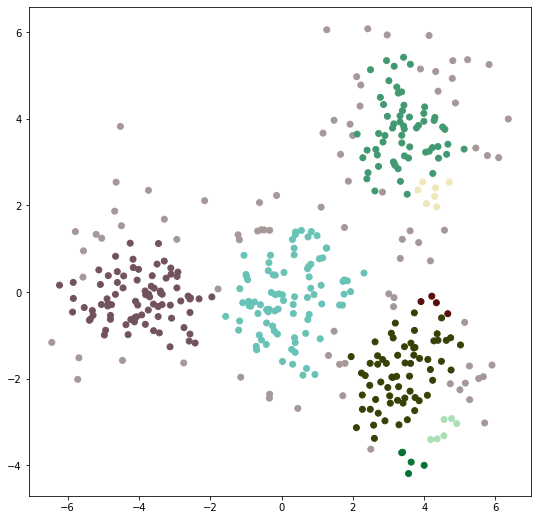

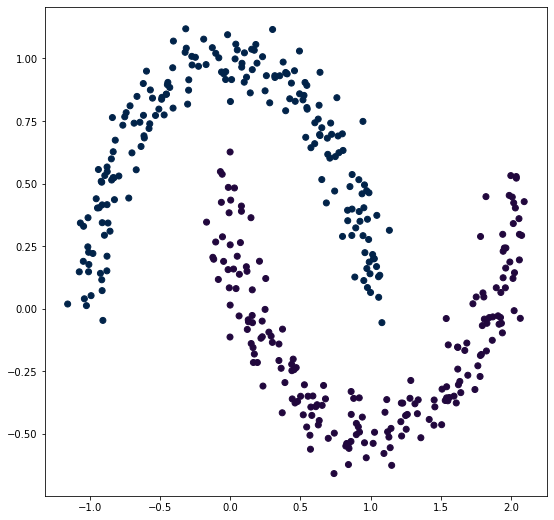

In [7]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [33]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.current_n_clusters = 0
        self.centroids = None
        self.distances = None
        self.X = None
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.X = X
        self.clusters = np.arange(X.shape[0])
        self.distances = np.array([[np.sqrt(np.sum((x - y) ** 2)) for y in X] for x in X])
        while len(np.unique(self.clusters)) > self.n_clusters:
            dists = self.calc_dists(self.clusters)
            min_ind = np.unravel_index(dists.argmin(), dists.shape)
            self.clusters = np.where(self.clusters == min_ind[1], min_ind[0], self.clusters)
            self.clusters = np.where(self.clusters > min_ind[1], self.clusters - 1, self.clusters)
        return self.clusters


    def calc_dists(self, clusters):
        size = len(np.unique(clusters))
        if self.linkage == "average":
            dists = np.zeros((size, size))
            count = np.zeros((size, size))
            for i in range(len(clusters)):
                for j in range(len(clusters)):
                    if i == j:
                        dists[clusters[i], clusters[j]] = np.inf
                        count[clusters[i], clusters[j]] = 1
                        continue
                    dists[clusters[i], clusters[j]] += self.distances[i, j]
                    count[clusters[i], clusters[j]] += 1
            return dists / count
        elif self.linkage == "single":
            dists = np.full((size, size), np.inf)
            for i in range(len(clusters)):
                for j in range(len(clusters)):
                    if i == j:
                        dists[clusters[i], clusters[j]] = np.inf
                        continue
                    dists[clusters[i], clusters[j]] = min(dists[clusters[i], clusters[j]], self.distances[i, j])
            return dists
        elif self.linkage == "complete":
            dists = np.zeros((size, size))
            for i in range(len(clusters)):
                for j in range(len(clusters)):
                    if i == j:
                        dists[clusters[i], clusters[j]] = np.inf
                        continue
                    dists[clusters[i], clusters[j]] = max(dists[clusters[i], clusters[j]], self.distances[i, j])
            return dists

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

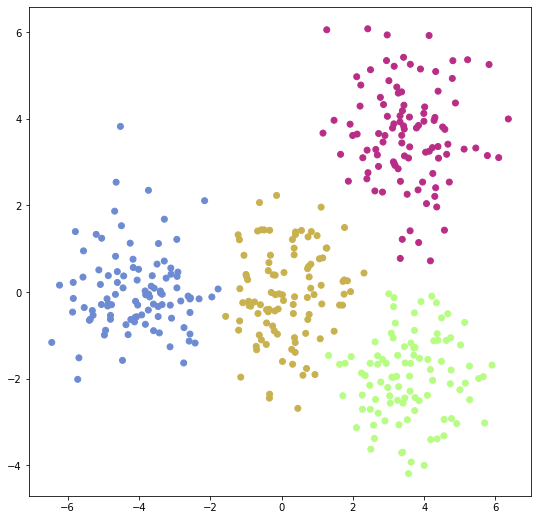

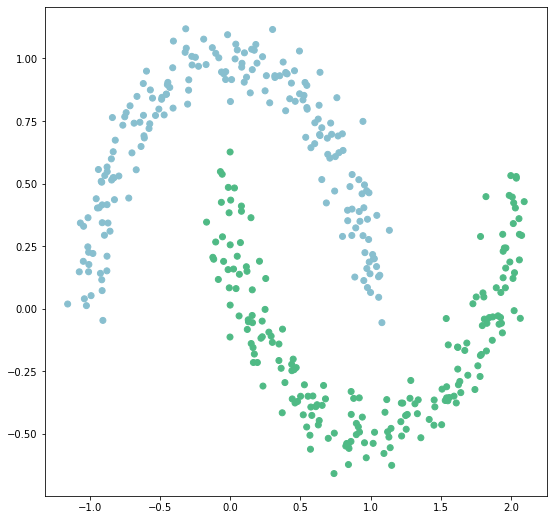

In [34]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='complete')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [8]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    return np.asarray(image[:, :, ::-1])


def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    cv2.imwrite(path,  np.asarray(image[:, :, ::-1]))    

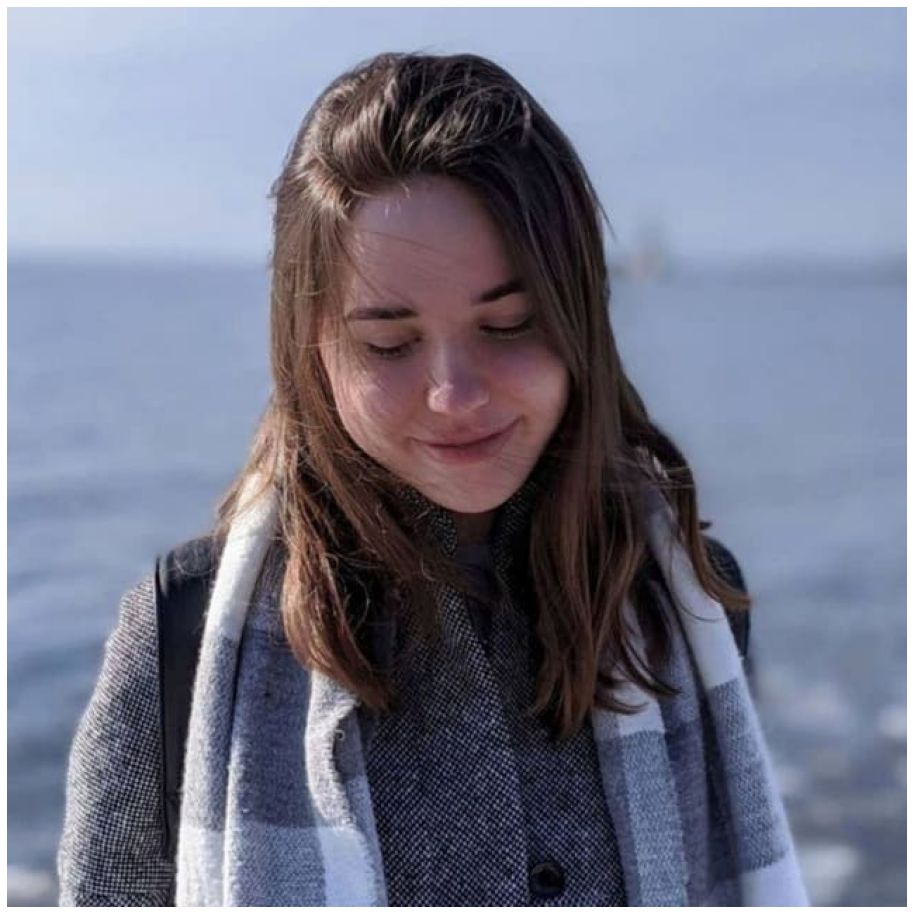

In [15]:
#show_image(read_image("./image.png"))
show_image(read_image("/home/maria/1.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [9]:
def clusterize_image(image, **kwargs):
    kmeans = KMeans(n_clusters=4, max_iter=4, init="k-means++")
    X = image.reshape(-1, 3)
    kmeans.fit(X)
    colors = np.array(kmeans.centroids) 
    clusters = np.array(kmeans.predict(X))
    recolored = np.array([[int(col[0]), int(col[1]), int(col[2])] for col in [colors[i] for i in clusters]]).reshape(len(image), len(image[0]), 3)
    # clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored

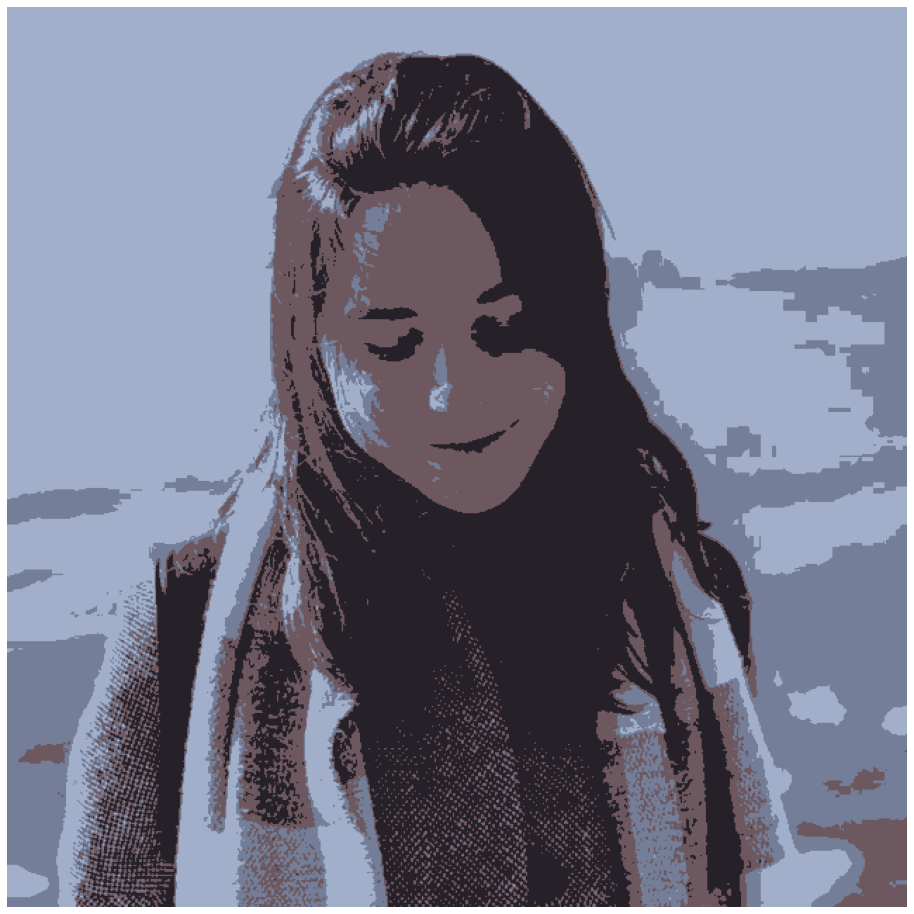

In [10]:
image = read_image("/home/maria/1.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "/home/maria/result.jpg")